In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
# pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [2]:
def preprocess(df):
    df = df.drop(['Lat', 'Long'], axis = 1)
    df = df.groupby(['Country/Region'], as_index = False).sum()
    df.loc[-1] = df.sum()
    df.loc[-1, 'Country/Region'] = 'Worldwide'
    countries = ['US', 'Germany', 'Spain', 'United Kingdom', 'France',
             'India', 'Iran', 'Italy', 'Russia', 'Turkey', 'Worldwide']
    df = df.loc[df['Country/Region'].isin(countries)]
    df.reset_index(drop = True, inplace = True)
    df = df.set_index('Country/Region')
    df.columns = pd.to_datetime(df.columns)
#   df.columns = pd.to_datetime(df.columns).dt.strftime('%d/%m/%Y')
    df = df.T
    return df

In [3]:
confirmed_df = pd.read_csv("./csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
confirmed_df = preprocess(confirmed_df)
deaths_df = pd.read_csv("./csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
deaths_df = preprocess(deaths_df)
recovered_df = pd.read_csv("./csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
recovered_df = preprocess(recovered_df)

In [4]:
active_df = pd.DataFrame(confirmed_df - deaths_df - recovered_df)
# recovered_df['2021-01-01':'2021-08-6']

In [5]:
# confirmed_df.plot()

In [6]:
# deaths_df.plot()

In [7]:
# recovered_df.plot()

## Train test split

In [8]:
active_train = active_df['2020-01-22':'2021-04-22']
active_test = active_df['2021-04-23':'2021-04-08']
confirmed_train = confirmed_df['2020-01-22':'2021-04-22']
confirmed_test = confirmed_df['2021-04-23':'2021-04-08']

In [17]:
confirmed_df['US']

2020-01-22           1
2020-01-23           1
2020-01-24           2
2020-01-25           2
2020-01-26           5
                ...   
2022-10-27    97418396
2022-10-28    97448572
2022-10-29    97457553
2022-10-30    97460811
2022-10-31    97505486
Name: US, Length: 1014, dtype: int64

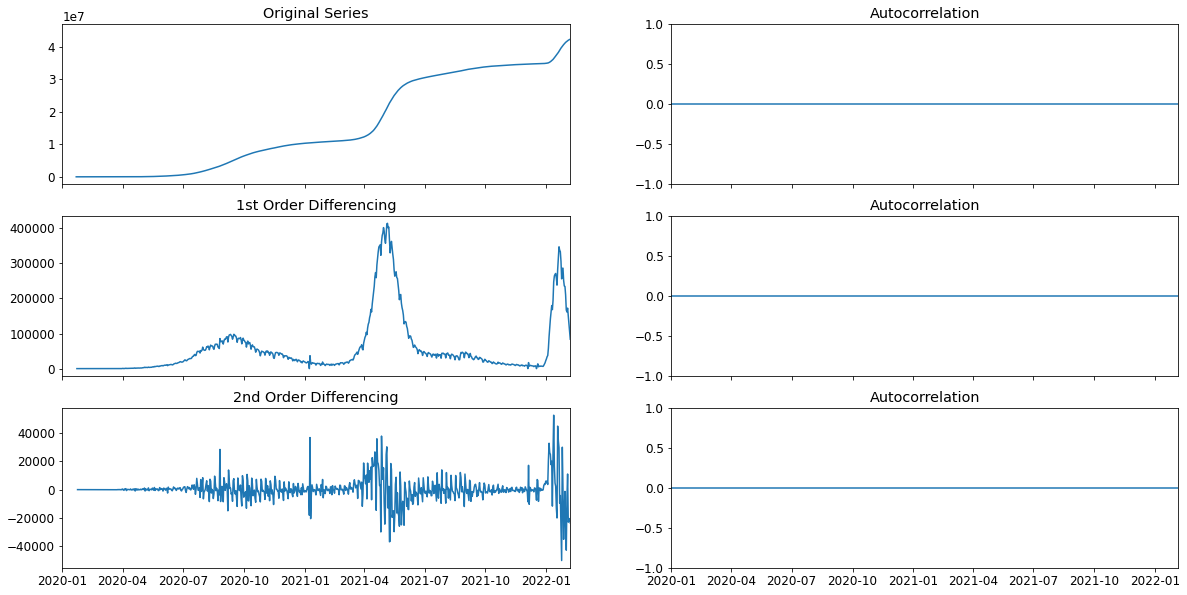

In [74]:
# Original Series
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = confirmed_df['India']#, 'Germany', 'Spain', 'United Kingdom', 'France', 'India', 'Iran', 'Italy', 'Russia', 'Turkey']
fig, axes = plt.subplots(3, 2, sharex=True)
for i in range(3):
    for j in range(2):
        axes[i, j].xaxis.get_data_interval()
        axes[i, j].set_xlim([date(2020, 1, 1), date(2022, 2, 5)])
axes[0, 0].plot(df)
axes[0, 0].set_title('Original Series')
# plot_acf(df, ax=axes[0, 1])
plot_acf(df.squeeze(), lags=40, ax = axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff())
axes[1, 0].set_title('1st Order Differencing')
# plot_acf(df.diff().dropna(), ax=axes[1, 1])
plot_acf(df.diff().squeeze(), lags=40, ax = axes[1, 1])


# 2nd Differencing
axes[2, 0].plot(df.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
# plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])
plot_acf(df.diff().diff().squeeze(), lags=40, ax = axes[2, 1])

plt.show()

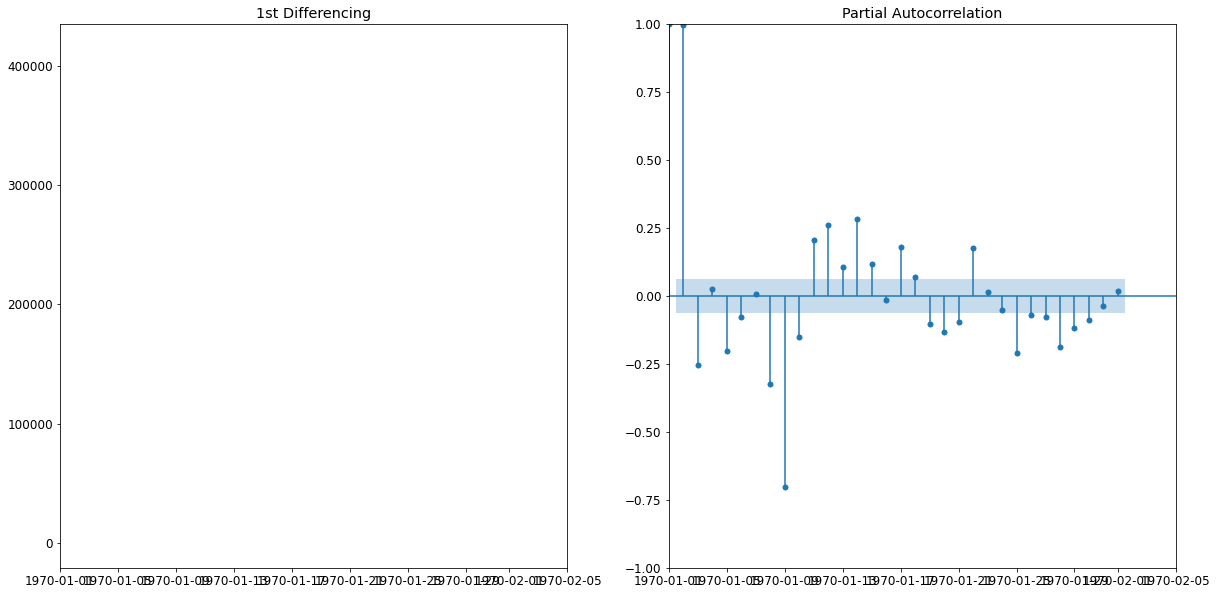

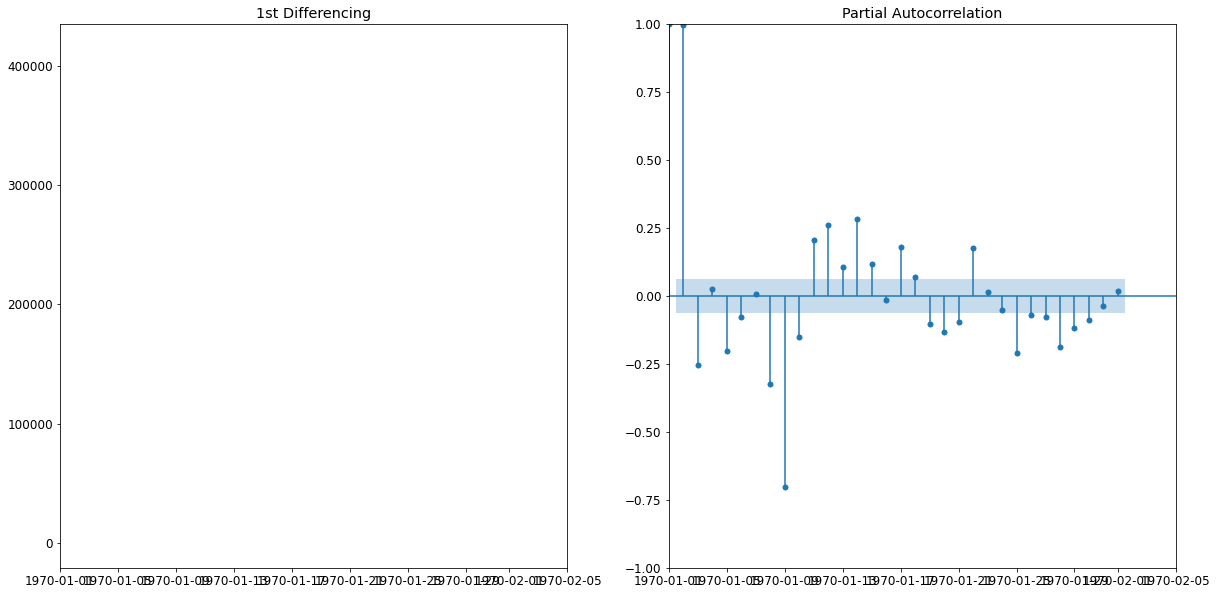

In [63]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.diff())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
axes[0].set_xlim([date(1970, 1, 1), date(1970, 2, 5)])
axes[1].set_xlim([date(1970, 1, 1), date(1970, 2, 5)])
plot_pacf(df.diff().dropna(), ax=axes[1])

In [64]:
# Define the p, d, q parameters
p = range(4, 12)
d = range(1, 2)
q = range(2, 6)

# Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))
pdq = [(9, 1, 2), (10, 1, 3), (8, 1, 4), (9, 1, 3)]

print('Examples of parameter combinations for ARIMA...')
print(f'ARIMA: {pdq[0]}')
print(f'ARIMA: {pdq[1]}')
print(f'ARIMA: {pdq[2]}')
print(f'ARIMA: {pdq[3]}')

Examples of parameter combinations for ARIMA...
ARIMA: (9, 1, 2)
ARIMA: (10, 1, 3)
ARIMA: (8, 1, 4)
ARIMA: (9, 1, 3)


In [12]:
MSE = []
ARIMA_model = []
for param in pdq:
    try:
        mod = sm.tsa.ARIMA(active_train['Worldwide'],
                                        order=param,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        print(f'ARIMA{param} - MSE:{results.mse}', end='\r')
        MSE.append(math.sqrt(results.mse))
        ARIMA_model.append(param)
        
    except:
        continue

In [13]:
print(f"The smallest MSE is {min(MSE)} for model ARIMA {ARIMA_model[MSE.index(min(MSE))][0]}x{ARIMA_model[MSE.index(min(MSE))][1]}")

The smallest MSE is 306058.1361020616 for model ARIMA 10x1


In [14]:
print(ARIMA_model)

[(9, 1, 2), (10, 1, 3), (8, 1, 4), (9, 1, 3)]


In [15]:
mod = sm.tsa.ARIMA(active_train['Worldwide'],
                                order=ARIMA_model[MSE.index(min(MSE))],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

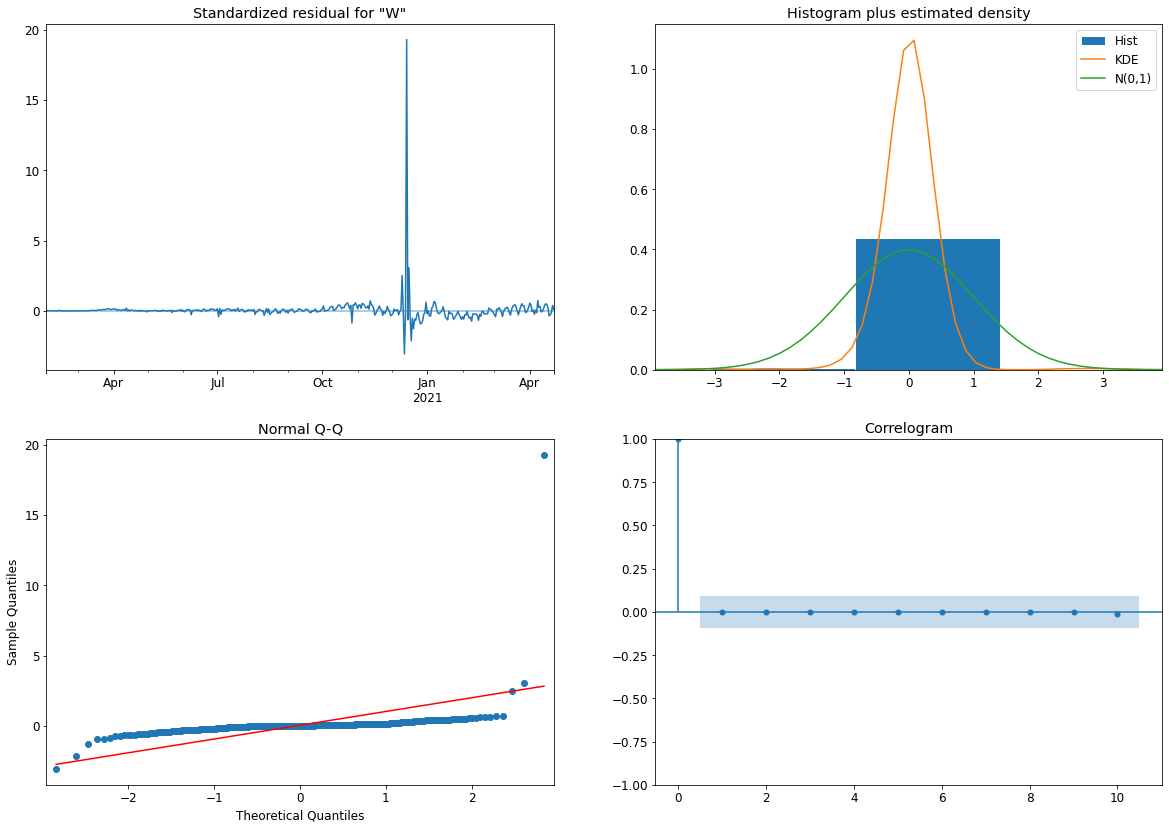

In [16]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()